In [95]:
from pylab import *
%matplotlib inline
import sys
import caffe
import os
import PIL
import scipy.io as sio
import tempfile
import numpy as np

In [2]:
import surgery, score
import os
import setproctitle
setproctitle.setproctitle(os.path.basename(os.getcwd()))

In [3]:
nyud_root = '/home/yangyong/fcn.berkeleyvision.org'

In [123]:
nyud_data_root = '/home/yangyong/fcn.berkeleyvision.org/data/nyud'

In [267]:
# Load net and weight
caffe.set_mode_cpu()

In [33]:
def guided_backprop(net,end):
    #threshold gradients
    keys = net.blobs.keys()
    nkeys = []
    for key in keys:
        nkeys.append(key)
        if(key == end):
            break
    for l in reversed(range(len(nkeys)-1)):
        layer = keys[l]
        next_layer = keys[l+1]

        if(layer == 'data'):
            imdiff = net.backward(start=next_layer)['data']
           
        else:

            relu_diff = net.blobs[next_layer].diff
            guidance = (relu_diff>0)*1
            if('relu' not in next_layer):
                net.backward(start=next_layer,end=layer)
                continue
            net.backward(start=next_layer,end=layer)[layer]
            
            net.blobs[layer].diff[...] = net.blobs[layer].diff * guidance
            
    return imdiff

In [4]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

In [1]:
import caffe
caffe_root = '/home/yangyong/caffe'

In [2]:
caffe.set_mode_cpu()

model_def =  '/home/yangyong/fcn.berkeleyvision.org/yongyang-project/sceneRecog/nyud-color-d-hha/deploy.prototxt'
model_weights = '/home/yangyong/fcn.berkeleyvision.org/yongyang-project/sceneRecog/nyud-color-d-hha/snapshot/train_iter_1300.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

In [27]:
net.bottom_names

OrderedDict([('input', []),
             ('conv1_bgrd', ['data']),
             ('relu1', ['conv1_bgrd']),
             ('pool1', ['conv1_bgrd']),
             ('norm1', ['pool1']),
             ('conv2', ['norm1']),
             ('relu2', ['conv2']),
             ('pool2', ['conv2']),
             ('norm2', ['pool2']),
             ('conv3', ['norm2']),
             ('relu3', ['conv3']),
             ('conv4', ['conv3']),
             ('relu4', ['conv4']),
             ('conv5', ['conv4']),
             ('relu5', ['conv5']),
             ('pool5', ['conv5']),
             ('fc6_new', ['pool5']),
             ('relu6', ['fc6_new']),
             ('drop6', ['fc6_new']),
             ('fc7_new', ['fc6_new']),
             ('relu7', ['fc7_new']),
             ('drop7', ['fc7_new']),
             ('scene_classifier', ['fc7_new']),
             ('probs', ['scene_classifier'])])

In [372]:
def compute_salience_maps(X,y,net,score_layer):
    """
    Compute a class saliency map using the test net for images X and labels y
    Input:
    - X: Input images, of shape (N, 3, H, W)
    - y: Labels for X, of shape (N,)
    - net: A PretrainedCNN that will be used to compute the saliency map.
  
    Returns:
    - saliency: An array of shape (N, H, W) giving the saliency maps for the input
    images.
    
    """
    saliency = None
    net.blobs['data'].data[...] = X
    ### perform classification
    output = net.forward()
    #output_prob = output['probs'][0]  # the output probability vector for the first image in the batch
    #print output_prob.argmax()
    score = net.blobs[score_layer].data
    dscore = np.zeros_like(score)
    dscore[:,y-1]=1.
    net.blobs[score_layer].diff[...] = dscore
    dX = net.backward(start = 'scene_classifier')['data']
    
    saliency = dX.max(axis=1)
    saliency = saliency[0]
    return saliency

In [229]:
import numpy as np
from PIL import Image
import scipy.io

import random

mean_bgr = np.array((116.190, 97.203, 92.318), dtype=np.float32)
mean_hha = np.array((194.421, 90.766, 126.557), dtype=np.float32)
mean_d = np.array((106.768,), dtype=np.float32)

def load_sceneLabel(nyud_dir,idx):
        """
        Load scene classification label 
        """
        allSceneLabel = scipy.io.loadmat('{}/sceneLabel/imgAllScene.mat'.format(nyud_dir))
        scenelabel = allSceneLabel['gtScene'][0][int(idx)-5001]
        return np.array([scenelabel])
def load_image(nyud_dir, idx):
        """
        Load input image and preprocess for Caffe:
        - cast to float
        - switch channels RGB -> BGR
        - subtract mean
        - transpose to channel x height x width order
        """
        im = Image.open('{}/data/images/img_{}.png'.format(nyud_dir, idx))
        in_ = np.array(im, dtype=np.float32)
        in_ = in_[:,:,::-1]
        in_ -= mean_bgr
        in_ = in_.transpose((2,0,1))
        return in_
    
def load_depth(nyud_dir, idx):
        """
        Load pre-processed depth for NYUDv2 segmentation set.
        """
        #im = Image.open('{}/depth/img_{}.png'.format(self.nyud_dir, idx))
        im = scipy.io.loadmat('{}/data/depth/img_{}.mat'.format(nyud_dir, idx))
        d = im['depths'].astype(np.float32)
        #d = np.log(d)
        d -= mean_d
        d = d[np.newaxis, ...]
        return d
    
def load_hha(nyud_dir, idx):
        """
        Load HHA features from Gupta et al. ECCV14.
        See https://github.com/s-gupta/rcnn-depth/blob/master/rcnn/saveHHA.m
        """
        im = Image.open('{}/data/hha/img_{}.png'.format(nyud_dir, idx))
        hha = np.array(im, dtype=np.float32)
        hha -= mean_hha
        hha = hha.transpose((2,0,1))
        return hha
    
allSceneLabel = sio.loadmat('{}/sceneLabel/imgAllScene.mat'.format(nyud_data_root))

In [347]:
scene_label_names = allSceneLabel['sceneName']
scene_label_names = label_names.flatten().flatten()

In [352]:
for i in range(len(scene_label_names)):
    scene_label_names[i] = scene_label_names[i][0]

In [394]:
# load input image 
def load_input(idx,features):
    is_color,is_d,is_hha = False ,False,False
    if 'color' in features:
        is_color = True
        color = load_image(nyud_data_root,idx)
    if 'depth' in features:
        is_d = True
        depth = load_depth(nyud_data_root,idx)
    if 'hha' in features:
        is_hha = True
        hha =  load_hha(nyud_data_root,idx)
    label = load_sceneLabel(nyud_data_root,idx)
    if is_color and not is_d and not is_hha:
        X = color
    if is_color and is_d and not is_hha:
        X = np.vstack((color,depth))
    if is_color and not is_d and is_hha:
        X = np.vstack((color,hha))
    if is_color and is_d and is_hha:
        X = np.vstack((color,depth,hha))
    if not is_color and not is_d and is_hha:
        X = hha
    X = X[np.newaxis,...]
    y = label[0]-1 # label should go form 0-26 not 1-27
    return X,y

In [268]:
test = np.loadtxt(nyud_data_root+'/test.txt', dtype=str)

In [395]:
X, y = load_input(test[9],['color','depth','hha'])

5723


In [396]:
scene_label_names[y]

u'bathroom'

(-0.5, 559.5, 424.5, -0.5)

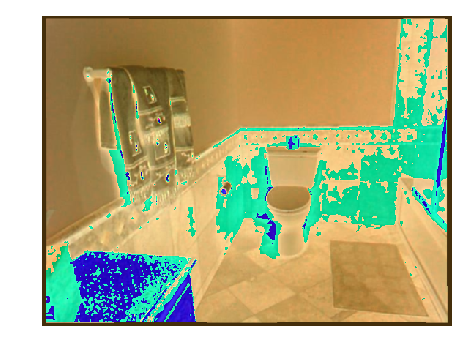

In [397]:
plt.imshow(X[0][0:3].transpose(1,2,0));axis('off')

(-0.5, 559.5, 424.5, -0.5)

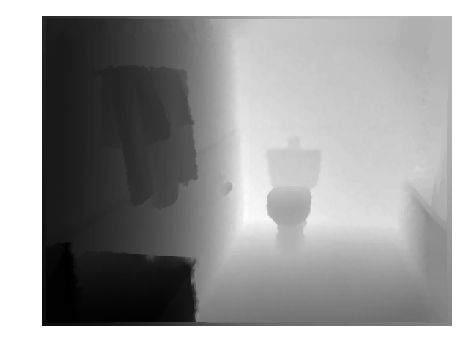

In [392]:
plt.imshow(X[0][3]);axis('off')

(-0.5, 559.5, 424.5, -0.5)

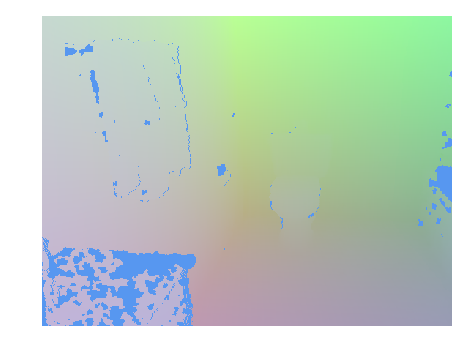

In [393]:
plt.imshow(X[0][4:7].transpose(1,2,0));axis('off')

In [284]:
print y
allSceneLabel['sceneName'][0][y-1][0]

2


u'bathroom'

In [497]:
sa = compute_salience_maps(X,y,net,'scene_classifier')

(-0.5, 559.5, 424.5, -0.5)

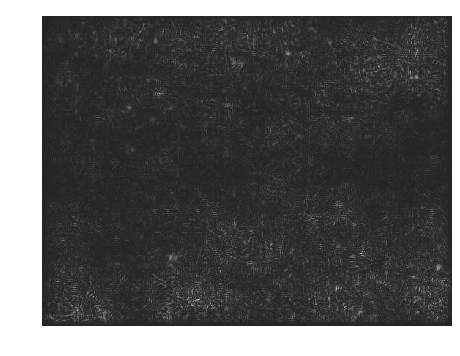

In [498]:
plt.imshow(sa);axis('off')

# Compute the test result and output confusion matrix

In [294]:
len(test)

351

In [401]:
import pandas as pd
from PIL import Image

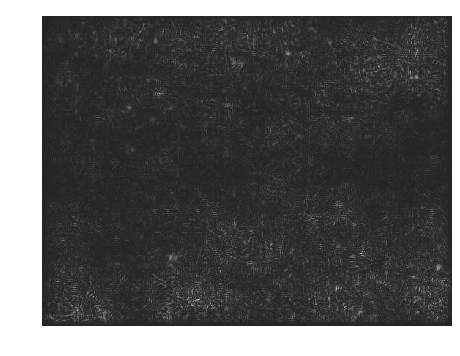

In [483]:
#i = 0
ground_truth = []
predictions = []
for i in range(len(test)):

    features = ['color','depth','hha']
    X,y = load_input(test[i],features)
    net.blobs['data'].data[...] = X
    output = net.forward() 
    output_probs = output['probs']
    # predict
    predict = output_probs.argmax()
    ground_truth.append(y) 
    predictions.append(predict)
    # top-5
    top_inds = output_prob.argsort()[::-1][:5]
    #top_5 = dict(zip(scene_label_names[top_inds-1],output_probs[0][top_inds],))
    top5 = pd.DataFrame()
    top5['scene_name'] = scene_label_names[top_inds]
    top5['probs'] = output_probs[0][top_inds]
    top5.to_csv('top5/img_{}_top5.csv'.format(test[i]))
    #compute saliency map
    sa = compute_salience_maps(X,y,net,'scene_classifier')
    plt.imshow(sa);axis('off')
    plt.savefig('sa/img_{}_sa.png'.format(test[i]))

In [408]:
from sklearn.metrics import confusion_matrix

In [431]:
conf_ma =  confusion_matrix(ground_truth,predictions,range(27))

In [432]:
conf_ma.shape

(27, 27)

([<matplotlib.axis.YTick at 0x7faa50b71dd0>,
 <a list of 27 Text yticklabel objects>)

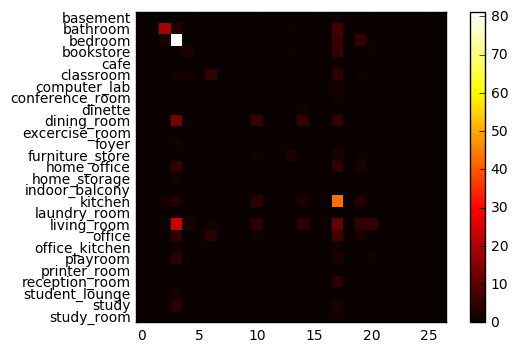

In [506]:
plt.imshow(conf_ma,cmap="hot");plt.colorbar();plt.yticks(np.arange(0,27),scene_label_names)

In [499]:
# compute accuracy and store it to csv table
#calculate the classes accuracy
scenes_lists = []
for i in xrange(27):
    scenes_lists.append([])
for i in xrange(len(ground_truth)):
    scenes_lists[int(ground_truth[i])].append(i)
    
result = np.zeros((2,27))
for i in xrange(27):
    num = len(scenes_lists[i])
    accu = nan
    correct = 0.
    if num!=0:
        for j in range(num):
            correct += sum(predictions[scenes_lists[i][j]] == ground_truth[scenes_lists[i][j]])
        accu = correct/num
    result[0][i] = num
    result[1][i] = accu

In [478]:
result.shape

(2, 27)

In [500]:
result_pd = pd.DataFrame()
result_pd['scene_name'] = scene_label_names
result_pd['num'] = result[0]
result_pd['accuracy'] = result[1]
result_pd.to_csv('test_result.csv')

In [501]:
result_pd

,scene_name,num,accuracy
0,basement,1.0,0.000000
1,bathroom,30.0,0.000000
2,bedroom,95.0,0.021053
3,bookstore,9.0,0.000000
4,cafe,1.0,0.000000
5,classroom,12.0,0.000000
6,computer_lab,1.0,0.000000
7,conference_room,1.0,0.000000
8,dinette,1.0,0.000000
9,dining_room,29.0,0.000000


# Visualize the paramters

In [464]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

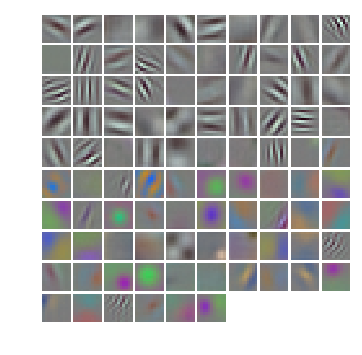

In [465]:
# conv1 rgb
filters_rgb = net.params['conv1_bgrd'][0].data[:,0:3,:,:]
#print filters_rgb
vis_square(filters_rgb.transpose(0, 2, 3, 1))

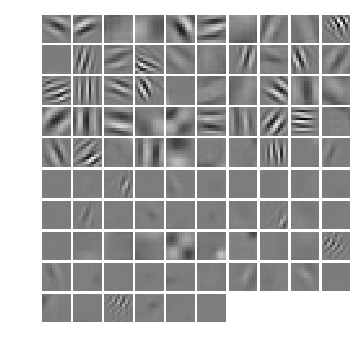

In [466]:
filters_d = net.params['conv1_bgrd'][0].data[:,3,:,:]
#print filters_d
vis_square(filters_d)

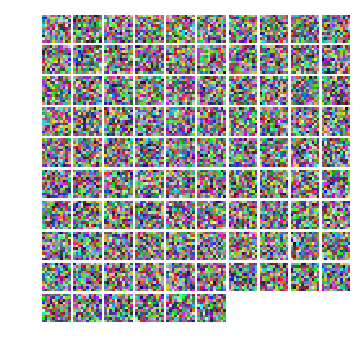

In [467]:
# conv1 rgb
filters_hha = net.params['conv1_bgrd'][0].data[:,4:7,:,:]
#print filters_rgb
vis_square(filters_hha.transpose(0, 2, 3, 1))

In [484]:
# Read sun-rgbd data

In [485]:
im = Image.open('/home/yangyong/Downloads/SUNRGBD/kv1/NYUdata/NYU0001/image/NYU0001.jpg')

In [487]:
arr = np.array(im)

In [489]:
arr.shape

(427, 561, 3)

In [490]:
depth = np.array(Image.open('/home/yangyong/Downloads/SUNRGBD/kv1/NYUdata/NYU0001/depth/NYU0001.png'))

In [494]:
depth

array([[21008, 21016, 21008, ..., 17216, 17224, 17216],
       [21032, 21032, 21008, ..., 17280, 17288, 17280],
       [21048, 21048, 21016, ..., 17344, 17352, 17352],
       ..., 
       [11728, 11760, 11824, ..., 15208, 15160, 15104],
       [11704, 11728, 11760, ..., 15208, 15168, 15112],
       [11680, 11704, 11744, ..., 15216, 15168, 15112]], dtype=int32)

In [492]:
depth_bfx = np.array(Image.open('/home/yangyong/Downloads/SUNRGBD/kv1/NYUdata/NYU0001/depth_bfx/NYU0001.png'))

In [495]:
depth_bfx

array([[21000, 21000, 21000, ..., 17224, 17224, 17224],
       [21000, 21000, 21000, ..., 17304, 17304, 17304],
       [21072, 21072, 21000, ..., 17376, 17376, 17376],
       ..., 
       [11752, 11752, 11832, ..., 15224, 15144, 15064],
       [11680, 11752, 11752, ..., 15224, 15144, 15144],
       [11680, 11680, 11752, ..., 15224, 15144, 15144]], dtype=int32)